#### Classify model from Yu, et al
Implementation of the classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Difference(s) from paper:
- Used to classify all defects, including none
- Run for 30 epochs instead of 80
- Resized to 224x224, but applied n=2 morphological thinning instead of median filter

None is randomly undersampled to 30,000.
Augmented with single-defect MixedWM38 samples.

In [ ]:
# !pip install pickle5

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [2]:
tf.__version__

'2.3.4'

In [3]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# specify variables
path = 'processed_data/WM-clean224-thin2'
filename = 'WM-clean224-thin2-wmmixed38aug'

result_path = 'results_yureruns'
model_id = 'yuclassify-all'
data_id = '224thin2'
note = '-wmmixed38aug' # -optional

In [5]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 1.017 seconds


['ids', 'labels', 'dataset', 'thinmap']

#### Data set-up

In [6]:
# prepare inputs
start = time.time()

x_train = data['thinmap'][data['dataset']=='train']
x_val = data['thinmap'][data['dataset']=='dev']
x_test = data['thinmap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 38.510 seconds
Train: (55878, 224, 224, 1)
Dev: (25942, 224, 224, 1)
Test: (25943, 224, 224, 1)


In [7]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.02 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


#### Model

In [8]:
# define model architecture

model = models.Sequential()
model.add(layers.Input(shape=(224, 224, 1)))
model.add(layers.experimental.preprocessing.RandomFlip(seed=424))
model.add(layers.experimental.preprocessing.RandomRotation(1, fill_mode='constant', interpolation='nearest', seed=424))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        3

In [9]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [10]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=30)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Epoch 1/30
437/437 [==============================] - 151s 346ms/step - loss: 0.6025 - accuracy: 0.8279 - val_loss: 0.2288 - val_accuracy: 0.9366
Epoch 2/30
437/437 [==============================] - 154s 352ms/step - loss: 0.2735 - accuracy: 0.9119 - val_loss: 0.1313 - val_accuracy: 0.9608
Epoch 3/30
437/437 [==============================] - 154s 353ms/step - loss: 0.2240 - accuracy: 0.9302 - val_loss: 0.1292 - val_accuracy: 0.9645
Epoch 4/30
437/437 [==============================] - 155s 354ms/step - loss: 0.2120 - accuracy: 0.9357 - val_loss: 0.1304 - val_accuracy: 0.9642
Epoch 5/30
437/437 [==============================] - 155s 355ms/step - loss: 0.2094 - accuracy: 0.9389 - val_loss: 0.1193 - val_accuracy: 0.9703
Epoch 6/30
437/437 [==============================] - 155s 355ms/step - loss: 0.2047 - accuracy: 0.9418 - val_loss: 0.1180 - val_accuracy: 0.9732
Epoch 7/30
437/437 [==============================] - 155s 354ms/step - loss: 0.2067 - accuracy: 0.9422 - val_loss: 0.1242 -

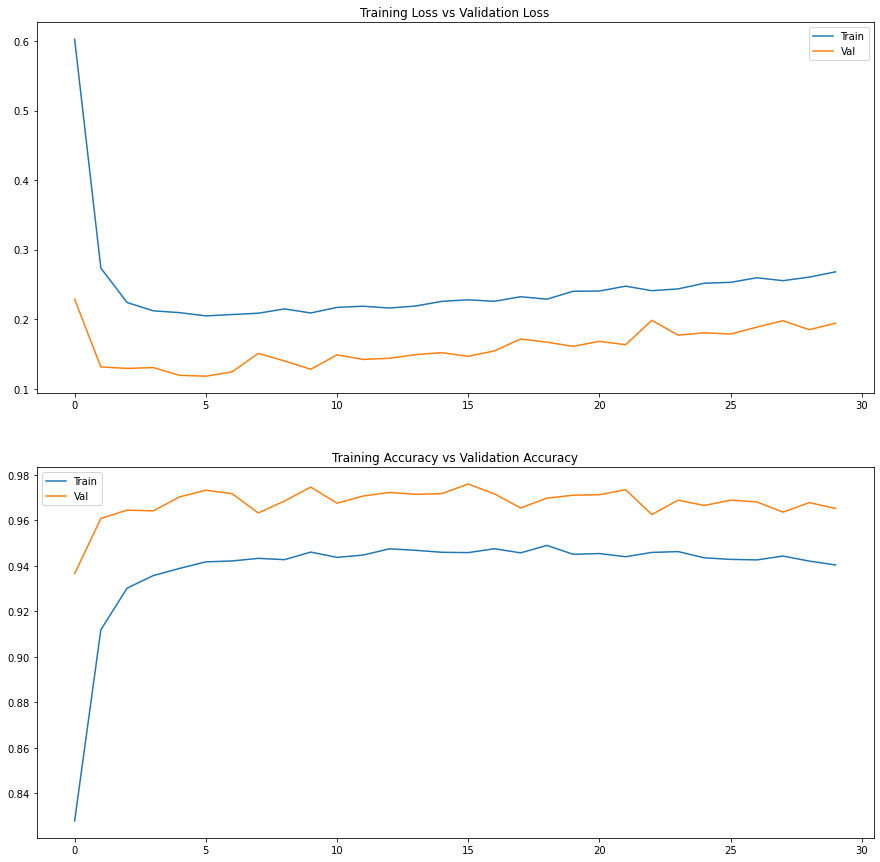

In [11]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [12]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp91dtb4k3/yuclassify-all-224thin2-wmmixed38aug/assets


In [13]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 18s 22ms/step - loss: 0.1918 - accuracy: 0.9661
Wall time: 18.92 seconds
[0.19178463518619537, 0.9660794734954834]


In [14]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 16.49 seconds


In [15]:
# save predictions to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

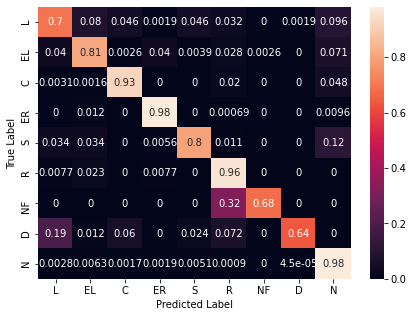

In [16]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

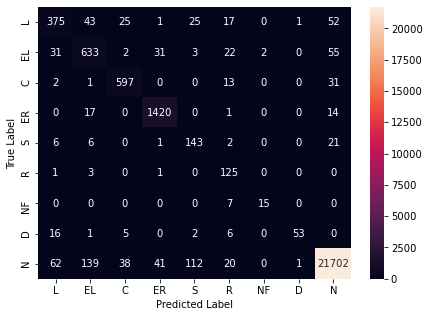

In [17]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)